In [1]:
import pandas as pd
import rrcf
import datetime
import numpy as np
import sys 
#sys.path.append('..')
#sys.path.insert(0, '')
from helpers import forest_to_dict
import seaborn as sns
import json

# Carga de datos

In [3]:
traffic_data = pd.read_csv('../data/bbva_esp_data/BBVA-ESP-MAD-MP-U-320592.csv')
traffic_data.head()

/Users/manuelpertejolope/anaconda3/envs/anomaly_python2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SC_ROUTER,DE_INTERFACE,NU_SPEED,NU_TRAFFIC_INPUT,NU_TRAFFIC_OUTPUT,DT_MEASURE_DATETIME,SC_INTERFACE_TYPE,DE_CUSTOMER_NAME,SD_ADMINISTRATIVE_NUMBER,WEEKEND
0,BBVA-ESP-MAD-MP-U-320592,GigabitEthernet0/2,1000.0,49.759952,1.749641,2018-02-01 00:00:00,WAN,BBVA,320592,False
1,BBVA-ESP-MAD-MP-U-320592,GigabitEthernet0/2,1000.0,44.669208,1.574221,2018-02-01 00:05:00,WAN,BBVA,320592,False
2,BBVA-ESP-MAD-MP-U-320592,GigabitEthernet0/2,1000.0,36.042612,1.300388,2018-02-01 00:10:00,WAN,BBVA,320592,False
3,BBVA-ESP-MAD-MP-U-320592,GigabitEthernet0/2,1000.0,0.000000,0.000000,2018-02-01 00:15:00,WAN,BBVA,320592,False
4,BBVA-ESP-MAD-MP-U-320592,GigabitEthernet0/2,1000.0,49.161688,1.586237,2018-02-01 00:20:00,WAN,BBVA,320592,False


In [6]:
traffic_data = traffic_data.loc[traffic_data.DE_INTERFACE == "GigabitEthernet0/2"]
traffic_data.shape

(218304, 10)

In [7]:
incidents_filtered = pd.read_csv('../data/bbva_esp_data/incidenciasBBVA-España.csv')
incidents_filtered.head() 

,TICKET_ID,SERVICE_TYPE,SUBMIT_DATE,LAST_MODIFICATION_DATE,ASSIGNED_SUPPORT_COMPANY,REPORTED_DATE,REPORTED_SOURCE_ID,OPERATING_COMPANY_NAME,OPERATING_LE,CONTACT_COMPANY_NAME,...,OPERATIONAL_CATEGORIZATION_TIER_2,OPERATIONAL_CATEGORIZATION_TIER_3,CLOSURE_CATEGORIZATION_TIER_1,CLOSURE_CATEGORIZATION_TIER_2,CLOSURE_CATEGORIZATION_TIER_3,VENDOR_GROUP,INF2_HPD_OUTAGE_DURATION,CI_COUNTRY,ADMIN_NUMBER,INSTANCEID
0,INC000001820715,User Service Restoration,2019-07-22 23:18:25,2019-07-23 03:00:26,Telefonica,2019-07-22 23:18:22,12001.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,Total Isolation,Total Isolation,NO DATA,NO DATA,NO DATA,NaN,0.0,Spain,20110621-SITEMPLS-0000320592,IDGAA5V0F6F35APVC6QPPUEY40KLHB
1,INC000001824417,User Service Restoration,2019-07-25 05:33:30,2019-07-25 05:36:37,Telefonica,2019-07-25 05:33:26,12001.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,Total Isolation,Total Isolation,Provider,Local Loop,Restored automatically without intervention,NaN,3.0,Spain,20110621-SITEMPLS-0000320592,IDGAA5V0F6F35APVGN5UPUJFD5QV1T
2,INC000001824755,User Service Restoration,2019-07-25 05:41:53,2019-07-26 03:00:05,Telefonica,2019-07-25 05:40:05,1000.0,Telefónica Venezuela (TELCEL),Banco Bilbao Vizcaya Argentaria (BBVA),NaN,...,Total Isolation,Total Isolation,NO DATA,NO DATA,NO DATA,Telefonica de España CCT Akamai,0.0,Spain,20110621-SITEMPLS-0000320592,AGGAA5V0F5WOOAPVGNTTPUJHUQMKTQ
3,INC000001824758,User Service Restoration,2019-07-25 05:45:25,2019-12-10 08:37:44,"TELEFONICA DE ESPAÑA, S.A.U.",2019-07-25 05:45:25,15001.0,"TELEFONICA DE ESPAÑA, S.A.U.",Telefonica de España CCT Akamai,Telefonica,...,Total Isolation,Total Isolation,NaN,NaN,NaN,Telefonica de España CCT Akamai,0.0,NaN,20110621-SITEMPLS-0000320592,AGGAA5V0F5WOOAPVGNZPPUJIAMMKY1
4,INC000001934182,User Service Restoration,2019-10-09 23:38:12,2019-10-18 02:06:44,Telefonica,2019-10-09 23:38:07,12001.0,TELCEL C.A. (TEL MOV VENEZUELA),TELCEL C.A. (TEL MOV VENEZUELA),NaN,...,Total Isolation,Total Isolation,Telefonica TIWS,International Backbone Network,Emergency work,NaN,18.0,Spain,20110621-SITEMPLS-0000320592,IDGAA5V0F5V26APZES1OPYHEUUCJ7J


# Fase de entrenamiento 

In [8]:
traffic_series = pd.Series(traffic_data.NU_TRAFFIC_INPUT.values, index = traffic_data.DT_MEASURE_DATETIME.values)
train_data = traffic_series['2019-01-01 00:00:00':'2019-03-31 23:55:00']
train_data = train_data[train_data != 0] 

In [9]:
num_trees = 50
tree_size = 512
train_index = train_data.index.values
forest = []
while len(forest) < num_trees:
    samples = np.random.choice(train_index, size = (num_trees, tree_size), replace = True)
    trees = [rrcf.RCTree(np.vstack(train_data.loc[sample].values), index_labels = sample) for sample in samples]
    forest.extend(trees) 

# Fase de scoring 

In [ ]:
test_data = traffic_series['2019-04-01 00:00:00':'2019-12-31 23:55:00']
codisp_no_shingle = pd.Series(0, index = test_data.index.values)

for next_index,next_point in test_data.items():
    for tree in forest:
        tree.insert_point(next_point, index=next_index)
        codisp_no_shingle[next_index] += tree.codisp(next_index)
        tree.forget_point(next_index)
avg_codisp_no_shingle = codisp_no_shingle/num_trees 

In [ ]:
avg_codisp_no_shingle.name = 'Anomaly score'
avg_codisp_no_shingle = avg_codisp_no_shingle.to_frame()
avg_codisp_no_shingle.reset_index(inplace=True)
avg_codisp_no_shingle.rename(columns={'index':'Date'}, inplace=True)
avg_codisp_no_shingle.describe()

In [ ]:
# Se puede guardar para su posterior uso
#avg_codisp_no_shingle.to_csv('../data/bbva_esp_data/bbva_esp_anomaly_score_abr_dic.csv', index = False)

# Selección de threshold estadístico

In [11]:
avg_codisp_no_shingle = pd.read_csv("../data/bbva_esp_data/bbva_esp_anomaly_score_abr_dic.csv")

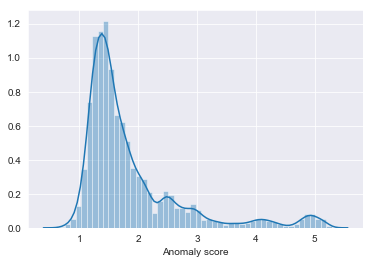

In [12]:
sns.set_style("darkgrid")
ax = sns.distplot(np.log(avg_codisp_no_shingle['Anomaly score']), label = "Anomaly Score")
ax

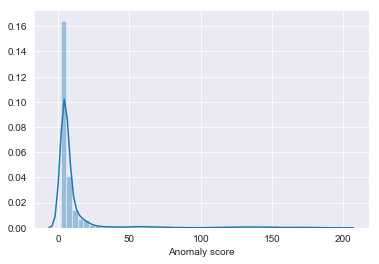

In [13]:
sns.set_style("darkgrid")
ax = sns.distplot(avg_codisp_no_shingle['Anomaly score'], label = "Anomaly Score")
ax

In [14]:
stat_threshold = avg_codisp_no_shingle["Anomaly score"].quantile(.99)
stat_threshold

152.64

In [17]:
# Creamos un archivo json donde guardamos los thresholds y el forest utilizado
forest_dict = forest_to_dict(forest) 
forest_dict["statistic_threshold"] = stat_threshold
with open('../data/bbva_esp_data/BBVA-ESP-MAD-MP-U-320592_GigabitEthernet02_input.json', 'w') as output_file:
    json.dump(forest_dict, output_file)